In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns

In [3]:
decals_classifications_loc = '/data/galaxy_zoo/weekly_dumps/2017-10-22_galaxy_zoo_decals_classifications.csv'

In [50]:
def get_decals_classifications(classifications_loc):
    df = pd.read_csv(classifications_loc, nrows=10000)
    # More things TODO e.g. filter by date, rename
    return df

In [51]:
df = get_decals_classifications(decals_classifications_loc)
print(len(df))
df.head()

10000


,id,subject_id,user,created_at,lang,user_agent,decals-0,decals-1,decals-2,decals-3,decals-4,decals-5,decals-6,decals-7,decals-8,decals-9,decals-10,decals-11
0,55e8b5061766270dbc005058,55a7d7a37a726119cd0006a0,KWillett,2015-09-03 21:00:54 UTC,en,unknown,a-1,a-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55e8b5151766270fb100516a,55a7d7a27a726119cd000582,KWillett,2015-09-03 21:01:09 UTC,en,unknown,a-1,a-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55e8b69117662710f8004e04,55a7d7a37a726119cd0007a1,KWillett,2015-09-03 21:07:29 UTC,en,unknown,a-1,a-1,a-0,a-0,a-2,a-1,a-2,NaN,NaN,a-1,a-0,a-0
3,55e8b6b417662710f8004e0d,55a7d7a37a726119cd0005e3,KWillett,2015-09-03 21:08:05 UTC,en,unknown,a-1,a-1,a-0,a-0,a-1,a-2,a-1,NaN,NaN,a-3,a-0,a-0
4,55e8b86e176627129b005008,55a7d7a27a726119cd00036c,KWillett,2015-09-03 21:15:26 UTC,en,unknown,a-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a-0,a-3,a-0,a-1


In [43]:
def count_if_value(series, value):
    return len(series[series == value])

def fraction_with_value(series, value):
    return count_if_value(series, value) / len(series)

In [72]:
def reduce_column(df, colname):
    unique_answers = df[colname].unique()
    
    counting_functions = [functools.partial(count_if_value, value=answer) for answer in unique_answers]
    counting_labels = [colname + '_' + answer + '_count' for answer in unique_answers]
    
    fraction_functions = [functools.partial(fraction_with_value, value=answer) for answer in unique_answers]
    fraction_labels = [colname + '_' + answer + '_fraction' for answer in unique_answers]
    
    subject_groups = df.groupby('subject_id')
    
    all_results = []
    for subject, data in subject_groups:
        counts = dict(zip(counting_labels, [func(data[colname]) for func in counting_functions]))
        fractions = dict(zip(fraction_labels, [func(data[colname]) for func in fraction_functions]))
        results = {**counts, **fractions}  # add dicts together
    
        results.update({'subject': subject})
        all_results.append(results)
        
    reduced_df = pd.DataFrame(all_results)
    return reduced_df, counting_labels, fraction_labels

In [73]:
featured_data, featured_count_cols, featured_fraction_cols = reduce_column(df, 'decals-0')
featured_data.head()

,decals-0_a-0_count,decals-0_a-0_fraction,decals-0_a-1_count,decals-0_a-1_fraction,decals-0_a-2_count,decals-0_a-2_fraction,subject
0,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd00000b
1,1,1.0,0,0.0,0,0.0,55a7d7a27a726119cd00002f
2,1,1.0,0,0.0,0,0.0,55a7d7a27a726119cd000033
3,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd000036
4,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd000037


In [82]:
def fraction_with_correct_answer(row):
    return row['decals-0_{}_fraction'.format(row['truth'])]
def fraction_with_most_confident_value(row):
    return row['decals-0_{}_fraction'.format(row['prediction'])]

In [ ]:
# def highest_vote_fraction(row, unique_answers):
#     row[['decals_0_{}_count'.format(answer) for answer in unique_answers]

In [85]:
col_with_most_counts = featured_data[featured_count_cols].idxmax(axis=1)
featured_data['prediction'] = col_with_most_counts.apply(lambda x: x.split('_')[1])
featured_data['confidence'] = featured_data.apply(fraction_with_most_confident_value, axis=1)

In [122]:
print(featured_data['prediction'].value_counts())

a-0    4736
a-1    2746
a-2     978
Name: prediction, dtype: int64


In [128]:
# pretend some true values, for now
featured_data['truth'] = [np.random.choice(df['decals-0'].unique()) for n in range(len(featured_data))]
featured_data['truth_confidence'] = featured_data.apply(fraction_with_correct_answer, axis=1)
featured_data.head()

,decals-0_a-0_count,decals-0_a-0_fraction,decals-0_a-1_count,decals-0_a-1_fraction,decals-0_a-2_count,decals-0_a-2_fraction,subject,prediction,confidence,truth,truth_int,prediction_int,truth_confidence
0,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd00000b,a-1,1.0,a-0,0,1,0.0
1,1,1.0,0,0.0,0,0.0,55a7d7a27a726119cd00002f,a-0,1.0,a-1,1,0,0.0
2,1,1.0,0,0.0,0,0.0,55a7d7a27a726119cd000033,a-0,1.0,a-2,0,0,0.0
3,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd000036,a-1,1.0,a-1,1,1,1.0
4,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd000037,a-1,1.0,a-0,2,1,0.0


In [119]:
encoder = preprocessing.LabelEncoder()
_ = encoder.fit(featured_data['prediction'])
featured_data['truth_int'] = encoder.transform(featured_data['truth'])
featured_data['prediction_int'] = encoder.transform(featured_data['prediction'])
featured_data.head()

,decals-0_a-0_count,decals-0_a-0_fraction,decals-0_a-1_count,decals-0_a-1_fraction,decals-0_a-2_count,decals-0_a-2_fraction,subject,prediction,confidence,truth,truth_int,prediction_int
0,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd00000b,a-1,1.0,a-0,0,1
1,1,1.0,0,0.0,0,0.0,55a7d7a27a726119cd00002f,a-0,1.0,a-1,1,0
2,1,1.0,0,0.0,0,0.0,55a7d7a27a726119cd000033,a-0,1.0,a-0,0,0
3,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd000036,a-1,1.0,a-1,1,1
4,0,0.0,1,1.0,0,0.0,55a7d7a27a726119cd000037,a-1,1.0,a-2,2,1


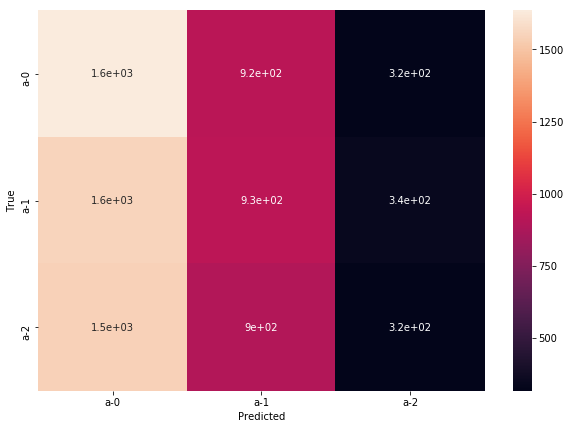

In [121]:
confusion_data = metrics.confusion_matrix(featured_data['truth_int'], featured_data['prediction_int'])
labels = encoder.inverse_transform(range(len(df['decals-0'].unique())))
df_cm = pd.DataFrame(
    confusion_data,
    index = [i for i in labels],
    columns = [i for i in labels])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True)
_ = ax.set_ylabel('True Label')
_ = ax.set_xlabel('Predicted Label')

In [126]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
    print(metrics.classification_report(featured_data['truth_int'], featured_data['prediction_int']))

             precision    recall  f1-score   support

          0       0.35      0.57      0.43      2874
          1       0.34      0.33      0.33      2826
          2       0.33      0.12      0.17      2760

avg / total       0.34      0.34      0.31      8460



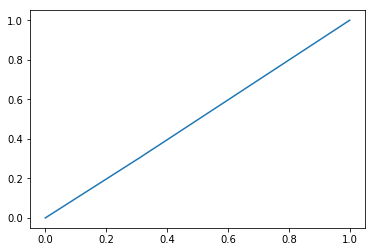

In [136]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, thresholds = metrics.roc_curve(featured_data['truth_int'], featured_data['truth_confidence'], pos_label=1)
plt.plot(fpr, tpr)

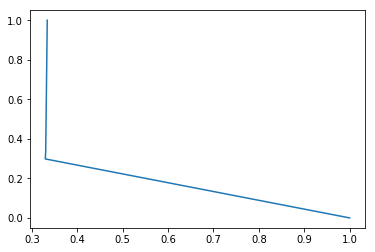

In [137]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve
precision, recall, thresholds = metrics.precision_recall_curve(featured_data['truth_int'], featured_data['truth_confidence'], pos_label=1)
plt.plot(precision, recall)

In [ ]:
# http://scikit-learn.org/stable/modules/calibration.html#calibration important for analysis later

In [117]:
pd.get_dummies(featured_data['truth'])  # I should use this for the counting


,a-0
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1
